# Imports

In [1]:
import os   # For path operations
import datetime

import hyperas
import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Config GPU env

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8349318874281187444
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9215183422
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1137299060274256201
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Def NN

## Training options

In [3]:
patience=40
early_stopping=EarlyStopping(monitor = 'val_loss', patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath="CNN_weights.hdf5", save_best_only=True, verbose =1)

## Create a 1D convnet based on the practice lesson for time series analysis

In [4]:
def make_1d_convnet(out_type,window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
    model = Sequential()
    # Defining input shape of the first layer based on desired output type
    if out_type == 'xyz':
        model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu', 
                       input_shape = (window_size,nb_input_series)))
    if out_type == 'rot':
        model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu', 
                       input_shape = (window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    return model

## Create input and output format from raw data

In [5]:
def make_timeseries_instances(out_type,timeseries, window_size, nb_inputs):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
    # nb_input defines the number of input time series that we use to predict outputs
    if out_type == 'xyz':
        X = np.atleast_3d(np.array([timeseries[start:start+window_size,:nb_inputs] for start in range(0,timeseries.shape[0]-window_size)]))
        for coord in range(3):
            np.roll(X[:,coord + 10],1) # Move xyz coordinates to the past
        np.delete(X,0,0)
    
    # We have 3 output signal: x, y and z position    
        y = timeseries[window_size:,-11:-8]
        np.delete(y,0,0)
        
    if out_type == 'rot':
        temp_arr=timeseries[:, np.r_[:10, 14:18]] # Load sensor data and orientation reference to input
        X = np.atleast_3d(np.array([temp_arr[start:start+window_size,:nb_inputs] for start in range(0,temp_arr.shape[0]-window_size)]))
        for coord in range(4):
            np.roll(X[:,coord + 10],1) # Move orientation coordinates to the past
        np.delete(X,0,0)
    
    # We have 4 output signal: Qx, Qy, Qz and Qw orientation    
        y = timeseries[window_size:,-7:-3]
        np.delete(y,0,0)
        
    return X,y

## Train the network on timeseries

In [6]:
def evalute_timeseries(out_type,timeseries, window_size, filter_length, nb_filter, epochs, batch_size):
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    
    # Define in and output size based on output type
    if out_type == 'xyz':
        nb_inputs = nb_series - 8 # Only 12 inputs (previous x,y,z position is an input now)
        nb_outputs = 3
    if out_type == 'rot':
        nb_inputs = nb_series - 7 # Only 13 inputs (previous Qx,Qy,Qz and Qw orientation is an input now)
        nb_outputs = 4
    
    # Initialize model
    model= make_1d_convnet(out_type,window_size=window_size, filter_length=filter_length, nb_input_series=nb_inputs,
                        nb_outputs=nb_outputs,nb_filter=nb_filter)
    model.summary()
  
    # Fill and split the input and output variables
    X,y = make_timeseries_instances(out_type,timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.3  * nb_samples)
    valid_size = int(0.2 * nb_samples)
    X_train, X_valid, X_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    # Train model
    model.fit(X_train,y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_valid, y_valid),
              verbose = 2, callbacks = [checkpointer,early_stopping])
  
    # Load the best model for plotting
    bestmodel = load_model("CNN_weights.hdf5")
    preds = bestmodel.predict(X_test)
    targets = y_test
    
    # Plot the results based on output type
    if out_type == 'xyz':
        # Plot predicted x vs target x
        plt.figure(0)
        plt.plot(preds[:,0],color = 'green', label = 'x pred')
        plt.plot(targets[:,0],color = 'red', label = 'x targ')
    
        # Plot predicted z vs target z
        plt.figure(1)
        plt.plot(preds[:,2],color = 'blue', label = 'z pred')
        plt.plot(targets[:,2],color = 'yellow', label = 'z targ')
    
        # Plot the predicted route vs original route on x-z plane
        plt.figure(2)
        plt.plot(preds[:,0],preds[:,2], label = 'xz pred')
        plt.plot(targets[:,0],targets[:,2], label = 'xz targ')
        
    if out_type == 'rot':
        plt.figure(0,figsize = (15,5))
        plt.plot(preds[:,0],color = 'red', label = 'Qx pred')
        plt.plot(targets[:,0],color = 'green', label = 'Qx targ')
        
        plt.figure(1,figsize = (15,5))
        plt.plot(preds[:,1],color = 'red', label = 'Qy pred')
        plt.plot(targets[:,1],color = 'green', label = 'Qy targ')
        
        plt.figure(2,figsize = (15,5))
        plt.plot(preds[:,2],color = 'red', label = 'Qz pred')
        plt.plot(targets[:,2],color = 'green', label = 'Qz targ')
        
        plt.figure(3,figsize = (15,5))
        plt.plot(preds[:,3],color = 'red', label = 'Qw pred')
        plt.plot(targets[:,3],color = 'green', label = 'Qw targ')

# Hyperas functions
## Input data processor

In [7]:
def data(timeseries): 
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    nb_inputs = nb_series - 8 #only 12 inputs (previous x,y,z position is an input now)
    window_size = 20
    
    #fill and split the input and output variables
    X,y = make_timeseries_instances(timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.15  * nb_samples)
    valid_size = int(0.15 * nb_samples)
    
    x_train, x_valid, x_test = X[:-(test_size+valid_size),:], X[-(test_size+valid_size):-test_size,:], X[-test_size:,:]
    y_train, y_valid, y_test = y[:-(test_size+valid_size),:], y[-(test_size+valid_size):-test_size,:], y[-test_size:,:]
    
    # Standardize input variables for train, valid and test data
    for inpt in range(X.shape[1]):
        scaler = preprocessing.StandardScaler().fit(x_train[:,inpt])
        x_train[:,inpt] = scaler.transform(x_train[:,inpt])
        x_valid[:,inpt] = scaler.transform(x_valid[:,inpt])
        x_test[:,inpt] = scaler.transform(x_test[:,inpt])
        
    return x_train, y_train, x_valid, y_valid, x_test, y_test

## Create a 1D CNN

In [8]:
def create_model(x_train, y_train, x_valid, y_valid, x_test, y_test):
    # Modifyable hyperparameters
    n_layer1 = {{choice([128, 256, 512])}}
    n_layer2 = {{choice([128, 256, 512])}}
    optim = {{choice(['rmsprop', 'adam', 'sgd'])}}
    n_batch = {{choice([16, 31, 64])}}
    
    # Constant parameters
    window_size = 20
    filter_length = 5
    nb_outputs=3
    
    # Creating model
    model = Sequential()
    model.add(Conv1D(filters = n_layer1, kernel_size = filter_length, activation = 'relu', 
                   input_shape = (window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters = n_layer2, kernel_size = filter_length, activation = 'relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation = 'linear'))
    model.compile(loss = 'mse', optimizer = optim, metrics = ['mae'])
    
    # Training model
    result = model.fit(x_train, y_train,
              batch_size = n_batch,
              epochs = 150,
              verbose = 2,
              validation_data = (x_valid, y_valid),
              callbacks = [checkpointer,early_stopping],
              shuffle = True)
    
    # Result output
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

# Load data file

In [9]:
df = pd.read_csv('Bazs\\PreprocessedData_v2.txt',
                               sep='\t',
                               decimal=',')
header = df.columns
df_arr =np.array(df, dtype='float64')
df =pd.DataFrame(df_arr, columns=header)

In [10]:
df.head(2)

delta_t    acc0    acc1    acc2   gyro0   gyro1   gyro2    mag0    mag1  \
0   0.0000 -0.0029  0.0003 -0.0003 -0.0194  0.0124 -0.0022 -0.5292 -0.6538   
1   0.0891 -0.0029  0.0013  0.0007 -0.0085  0.0023  0.0006 -0.5292 -0.6538   

     mag2   ...         y      z    beta     Qx    Qy     Qz   Qw  delta_x  \
0 -0.5275   ...     0.221  0.402 -0.0129  0.005  0.02  0.000  1.0      0.0   
1 -0.4945   ...     0.221  0.402 -0.0128  0.005  0.02  0.001  1.0      0.0   

   delta_y  delta_z  
0      0.0      0.0  
1      0.0      0.0  

[2 rows x 21 columns]

# Set hyperparameters

In [11]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 500
batch_size = 16
validation_split = 0.2

# Train NN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             264       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 375
Trainable params: 375
Non-trainable params: 0
_________________________________________________________________
Train on 382

 - 1s - loss: 3.6866e-04 - mean_absolute_error: 0.0124 - val_loss: 6.7008e-04 - val_mean_absolute_error: 0.0176

Epoch 00037: val_loss did not improve from 0.00052
Epoch 38/500
 - 1s - loss: 3.7521e-04 - mean_absolute_error: 0.0126 - val_loss: 6.4189e-04 - val_mean_absolute_error: 0.0178

Epoch 00038: val_loss did not improve from 0.00052
Epoch 39/500
 - 1s - loss: 3.6215e-04 - mean_absolute_error: 0.0125 - val_loss: 6.0462e-04 - val_mean_absolute_error: 0.0170

Epoch 00039: val_loss did not improve from 0.00052
Epoch 40/500
 - 1s - loss: 3.5496e-04 - mean_absolute_error: 0.0123 - val_loss: 3.6311e-04 - val_mean_absolute_error: 0.0131

Epoch 00040: val_loss improved from 0.00052 to 0.00036, saving model to CNN_weights.hdf5
Epoch 41/500
 - 1s - loss: 3.5121e-04 - mean_absolute_error: 0.0123 - val_loss: 5.1911e-04 - val_mean_absolute_error: 0.0154

Epoch 00041: val_loss did not improve from 0.00036
Epoch 42/500
 - 1s - loss: 3.3778e-04 - mean_absolute_error: 0.0120 - val_loss: 5.0279e-04

 - 1s - loss: 2.0025e-04 - mean_absolute_error: 0.0094 - val_loss: 3.5643e-04 - val_mean_absolute_error: 0.0133

Epoch 00083: val_loss did not improve from 0.00033
Epoch 84/500
 - 1s - loss: 2.0593e-04 - mean_absolute_error: 0.0095 - val_loss: 6.2628e-04 - val_mean_absolute_error: 0.0182

Epoch 00084: val_loss did not improve from 0.00033
Epoch 85/500
 - 1s - loss: 1.9390e-04 - mean_absolute_error: 0.0092 - val_loss: 3.7015e-04 - val_mean_absolute_error: 0.0134

Epoch 00085: val_loss did not improve from 0.00033
Epoch 86/500
 - 1s - loss: 1.8384e-04 - mean_absolute_error: 0.0091 - val_loss: 6.7257e-04 - val_mean_absolute_error: 0.0181

Epoch 00086: val_loss did not improve from 0.00033
Epoch 87/500
 - 1s - loss: 1.9860e-04 - mean_absolute_error: 0.0093 - val_loss: 8.0056e-04 - val_mean_absolute_error: 0.0216

Epoch 00087: val_loss did not improve from 0.00033
Epoch 88/500
 - 1s - loss: 2.0917e-04 - mean_absolute_error: 0.0096 - val_loss: 4.2291e-04 - val_mean_absolute_error: 0.0146

Ep

 - 1s - loss: 1.4146e-04 - mean_absolute_error: 0.0080 - val_loss: 2.9567e-04 - val_mean_absolute_error: 0.0120

Epoch 00129: val_loss did not improve from 0.00022
Epoch 130/500
 - 1s - loss: 1.4177e-04 - mean_absolute_error: 0.0080 - val_loss: 3.2324e-04 - val_mean_absolute_error: 0.0128

Epoch 00130: val_loss did not improve from 0.00022
Epoch 131/500
 - 1s - loss: 1.3609e-04 - mean_absolute_error: 0.0078 - val_loss: 2.3313e-04 - val_mean_absolute_error: 0.0109

Epoch 00131: val_loss did not improve from 0.00022
Epoch 132/500
 - 1s - loss: 1.2577e-04 - mean_absolute_error: 0.0075 - val_loss: 3.7307e-04 - val_mean_absolute_error: 0.0133

Epoch 00132: val_loss did not improve from 0.00022
Epoch 133/500
 - 1s - loss: 1.4696e-04 - mean_absolute_error: 0.0081 - val_loss: 3.8551e-04 - val_mean_absolute_error: 0.0142

Epoch 00133: val_loss did not improve from 0.00022
Epoch 134/500
 - 1s - loss: 1.4743e-04 - mean_absolute_error: 0.0081 - val_loss: 4.8136e-04 - val_mean_absolute_error: 0.016

 - 1s - loss: 1.1227e-04 - mean_absolute_error: 0.0071 - val_loss: 3.3234e-04 - val_mean_absolute_error: 0.0128

Epoch 00175: val_loss did not improve from 0.00019
Epoch 176/500
 - 1s - loss: 1.0463e-04 - mean_absolute_error: 0.0069 - val_loss: 2.8806e-04 - val_mean_absolute_error: 0.0120

Epoch 00176: val_loss did not improve from 0.00019
Epoch 177/500
 - 1s - loss: 1.1515e-04 - mean_absolute_error: 0.0073 - val_loss: 3.0664e-04 - val_mean_absolute_error: 0.0127

Epoch 00177: val_loss did not improve from 0.00019
Epoch 178/500
 - 1s - loss: 1.3118e-04 - mean_absolute_error: 0.0076 - val_loss: 4.0877e-04 - val_mean_absolute_error: 0.0149

Epoch 00178: val_loss did not improve from 0.00019
Epoch 179/500
 - 1s - loss: 1.2052e-04 - mean_absolute_error: 0.0073 - val_loss: 3.3544e-04 - val_mean_absolute_error: 0.0127

Epoch 00179: val_loss did not improve from 0.00019
Epoch 180/500
 - 1s - loss: 1.0770e-04 - mean_absolute_error: 0.0070 - val_loss: 4.1505e-04 - val_mean_absolute_error: 0.015

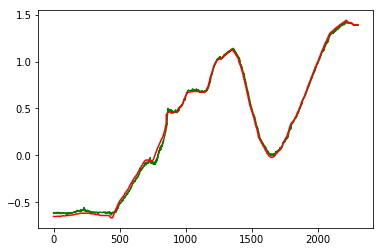

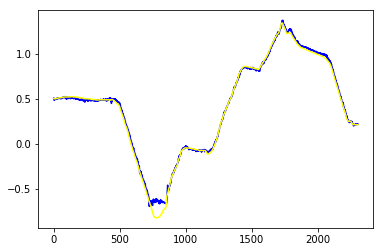

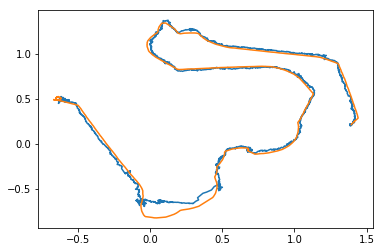

In [12]:
#use 'xyz' or 'rot' to choose output
evalute_timeseries('xyz',df,window_size,filter_length,nb_filter, epochs, batch_size)

# Draw xz position prediction with the model (previous position is the reference data)

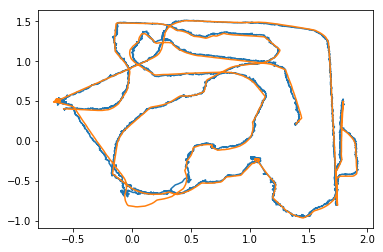

In [18]:
# Predict with reference dataset
X,y = make_timeseries_instances('xyz',df, window_size,nb_inputs=13)
model = load_model("CNN_weights.hdf5")
y_pred = model.predict(X)
plt.figure(0)
plt.plot(y_pred[:,0],y_pred[:,2], label='xz pred')
plt.plot(y[:,0],y[:,2], label='xz targ')

# Draw xz position prediction with the model (previous position is predicted)

(7658, 20, 13)
(7658, 3)


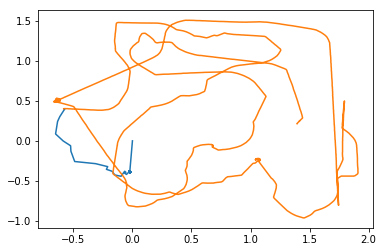

In [39]:
# Predict with calculated data
newX=X
print(newX.shape)
print(y.shape)

newy_pred=np.empty(y.shape)
for index in range(y.shape[0]-1):
    if index > 0:
        temp=newX[index,-1]
        newX[index]=np.roll(newX[index-1],-1, axis=0)
        newX[index,-1]=temp
        for coord in range(3):  
            newX[index,-1,coord+10]=newy_pred[index,coord]
    tmp=np.empty((1,20,13))
    tmp[0]=newX[index]
    newy_pred[index]=model.predict(tmp)
    
plt.figure(0)
plt.plot(newy_pred[:,0],newy_pred[:,2], label='xz pred')
plt.plot(y[:,0],y[:,2], label='xz targ')

# Hyperas optimization

In [ ]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# main hyperopt part
# az algoritmus lehet:
# -- random.suggest -> random search
# -- tpe.suggest -> tree parsen estimator
best_run, best_model = optim.minimize(model=create_model,
                                          data=data(timeData),
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                        notebook_name='CNN_Mark')
#x_train, y_train, x_valid, y_valid, x_test, y_test = data(timeData)
#print("Evalutation of best performing model:")
#print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
